Loaded 6148 satellites


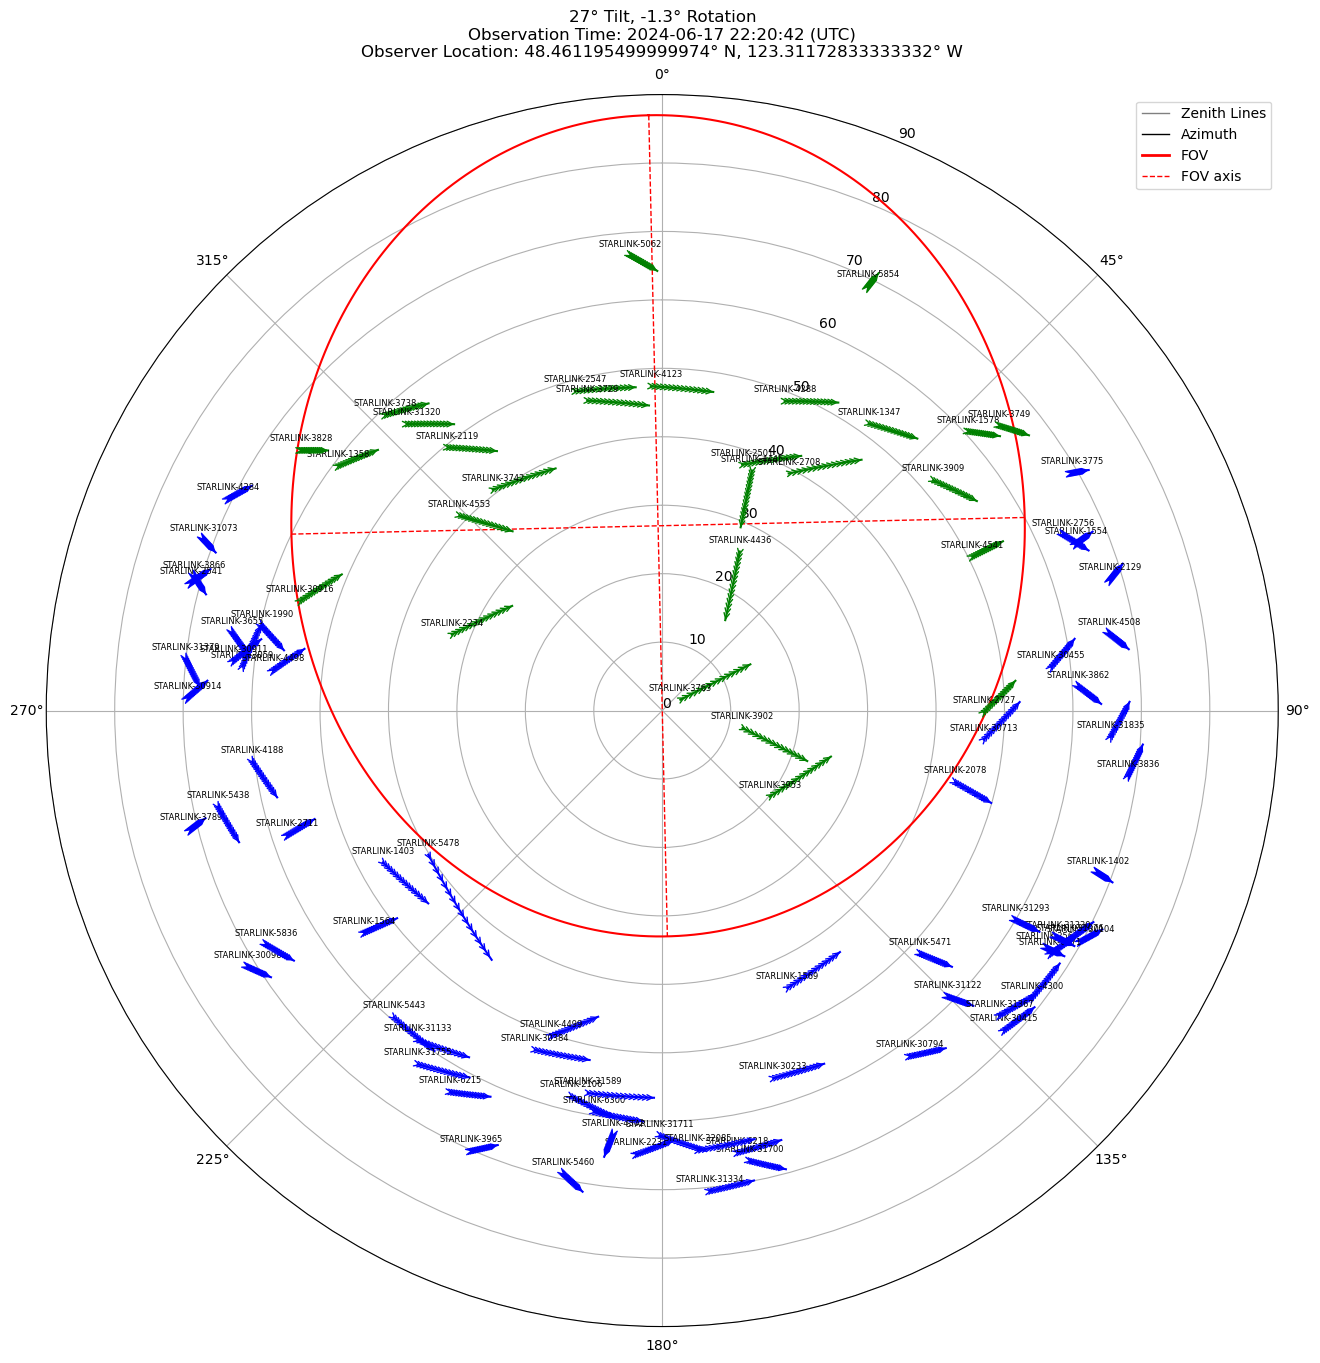

Satellites inside the FOV: ['STARLINK-1358', 'STARLINK-1347', 'STARLINK-1578', 'STARLINK-2119', 'STARLINK-2547', 'STARLINK-2501', 'STARLINK-2234', 'STARLINK-2727', 'STARLINK-2708', 'STARLINK-3738', 'STARLINK-3729', 'STARLINK-3742', 'STARLINK-3749', 'STARLINK-3909', 'STARLINK-3828', 'STARLINK-3902', 'STARLINK-3763', 'STARLINK-3953', 'STARLINK-4288', 'STARLINK-4541', 'STARLINK-4445', 'STARLINK-4436', 'STARLINK-4123', 'STARLINK-4553', 'STARLINK-5062', 'STARLINK-5854', 'STARLINK-30916', 'STARLINK-31320']


In [1]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 60
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces with arrows
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        color = "g" if inside else "b"
        ax.plot(angle, r, color=color)
        for i in range(0, len(angle) - 1, max(1, len(angle) // 10)):
            ax.annotate('', xy=(angle[i + 1], r[i + 1]), xytext=(angle[i], r[i]),
                        arrowprops=dict(arrowstyle='->', color=color))
        if inside:
            inside_fov.append(satellite_name)
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 6, 17, 22, 20, 42)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    draw_fov(27, -1.3, positions_over_time, initial_time, observer_location)


Loaded 6148 satellites


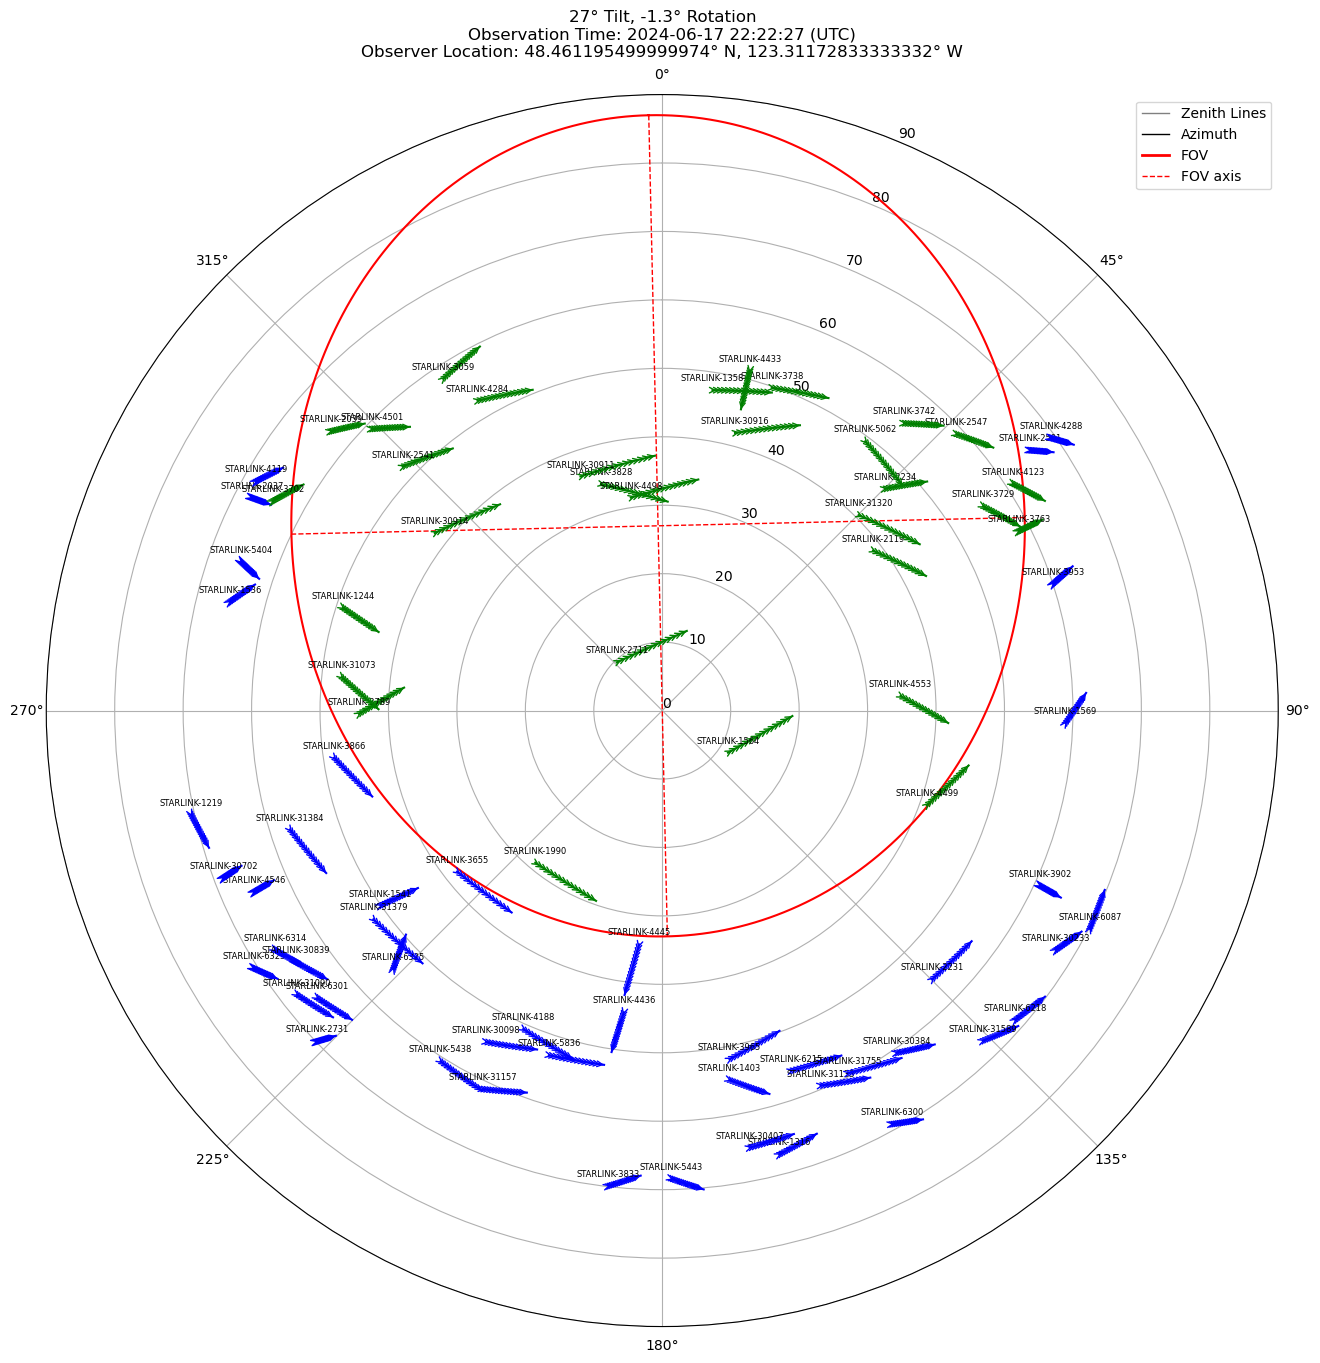

Satellites inside the FOV: ['STARLINK-1244', 'STARLINK-1358', 'STARLINK-1564', 'STARLINK-2119', 'STARLINK-1990', 'STARLINK-2039', 'STARLINK-2547', 'STARLINK-2541', 'STARLINK-2234', 'STARLINK-2711', 'STARLINK-3059', 'STARLINK-3702', 'STARLINK-3738', 'STARLINK-3729', 'STARLINK-3789', 'STARLINK-3742', 'STARLINK-3828', 'STARLINK-3763', 'STARLINK-4284', 'STARLINK-4499', 'STARLINK-4498', 'STARLINK-4433', 'STARLINK-4123', 'STARLINK-4501', 'STARLINK-4553', 'STARLINK-5062', 'STARLINK-30911', 'STARLINK-30914', 'STARLINK-30916', 'STARLINK-31073', 'STARLINK-31320']


In [10]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 60
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces with arrows
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        color = "g" if inside else "b"
        ax.plot(angle, r, color=color)
        for i in range(0, len(angle) - 1, max(1, len(angle) // 10)):
            ax.annotate('', xy=(angle[i + 1], r[i + 1]), xytext=(angle[i], r[i]),
                        arrowprops=dict(arrowstyle='->', color=color))
        if inside:
            inside_fov.append(satellite_name)
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 6, 17, 22, 22, 27)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    draw_fov(27, -1.3, positions_over_time, initial_time, observer_location)


Loaded 6148 satellites


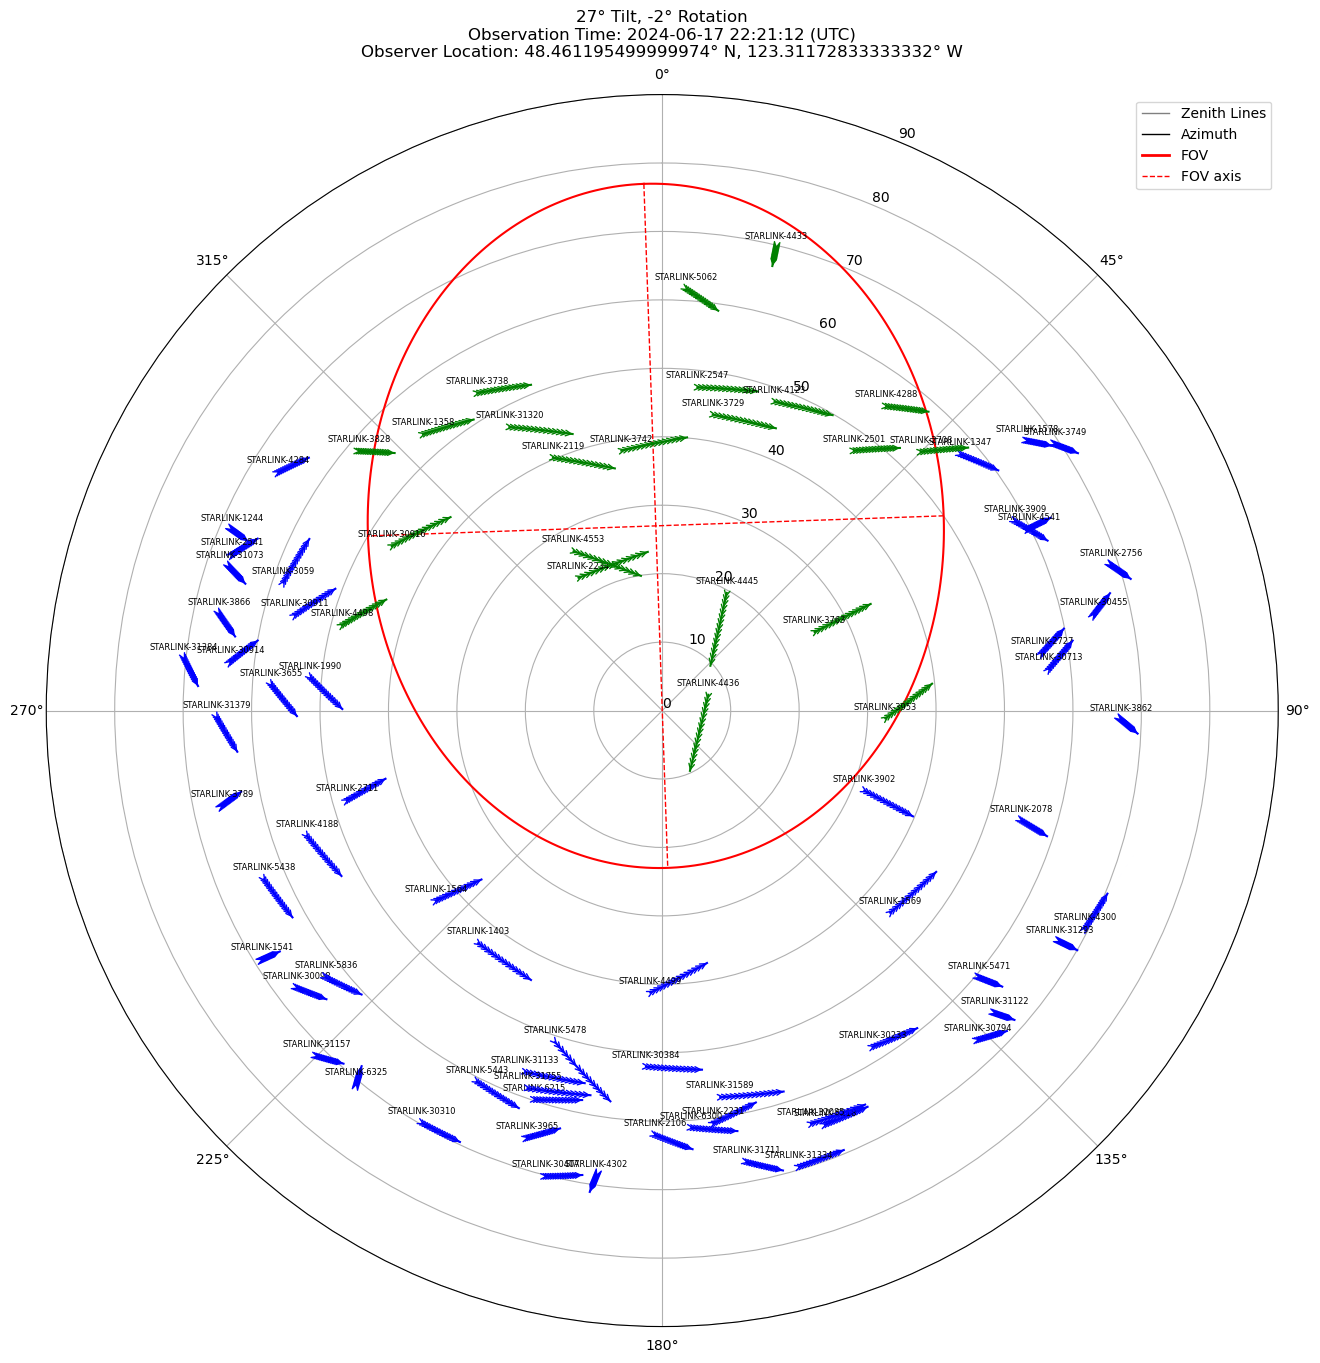

Satellites inside the FOV: ['STARLINK-1358', 'STARLINK-2119', 'STARLINK-2547', 'STARLINK-2501', 'STARLINK-2234', 'STARLINK-2708', 'STARLINK-3738', 'STARLINK-3729', 'STARLINK-3742', 'STARLINK-3828', 'STARLINK-3763', 'STARLINK-3953', 'STARLINK-4288', 'STARLINK-4498', 'STARLINK-4445', 'STARLINK-4433', 'STARLINK-4436', 'STARLINK-4123', 'STARLINK-4553', 'STARLINK-5062', 'STARLINK-30916', 'STARLINK-31320']


In [11]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 50
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces with arrows
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        color = "g" if inside else "b"
        ax.plot(angle, r, color=color)
        for i in range(0, len(angle) - 1, max(1, len(angle) // 10)):
            ax.annotate('', xy=(angle[i + 1], r[i + 1]), xytext=(angle[i], r[i]),
                        arrowprops=dict(arrowstyle='->', color=color))
        if inside:
            inside_fov.append(satellite_name)
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 6, 17, 22, 21, 12)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    draw_fov(27, -2, positions_over_time, initial_time, observer_location)


Loaded 6148 satellites


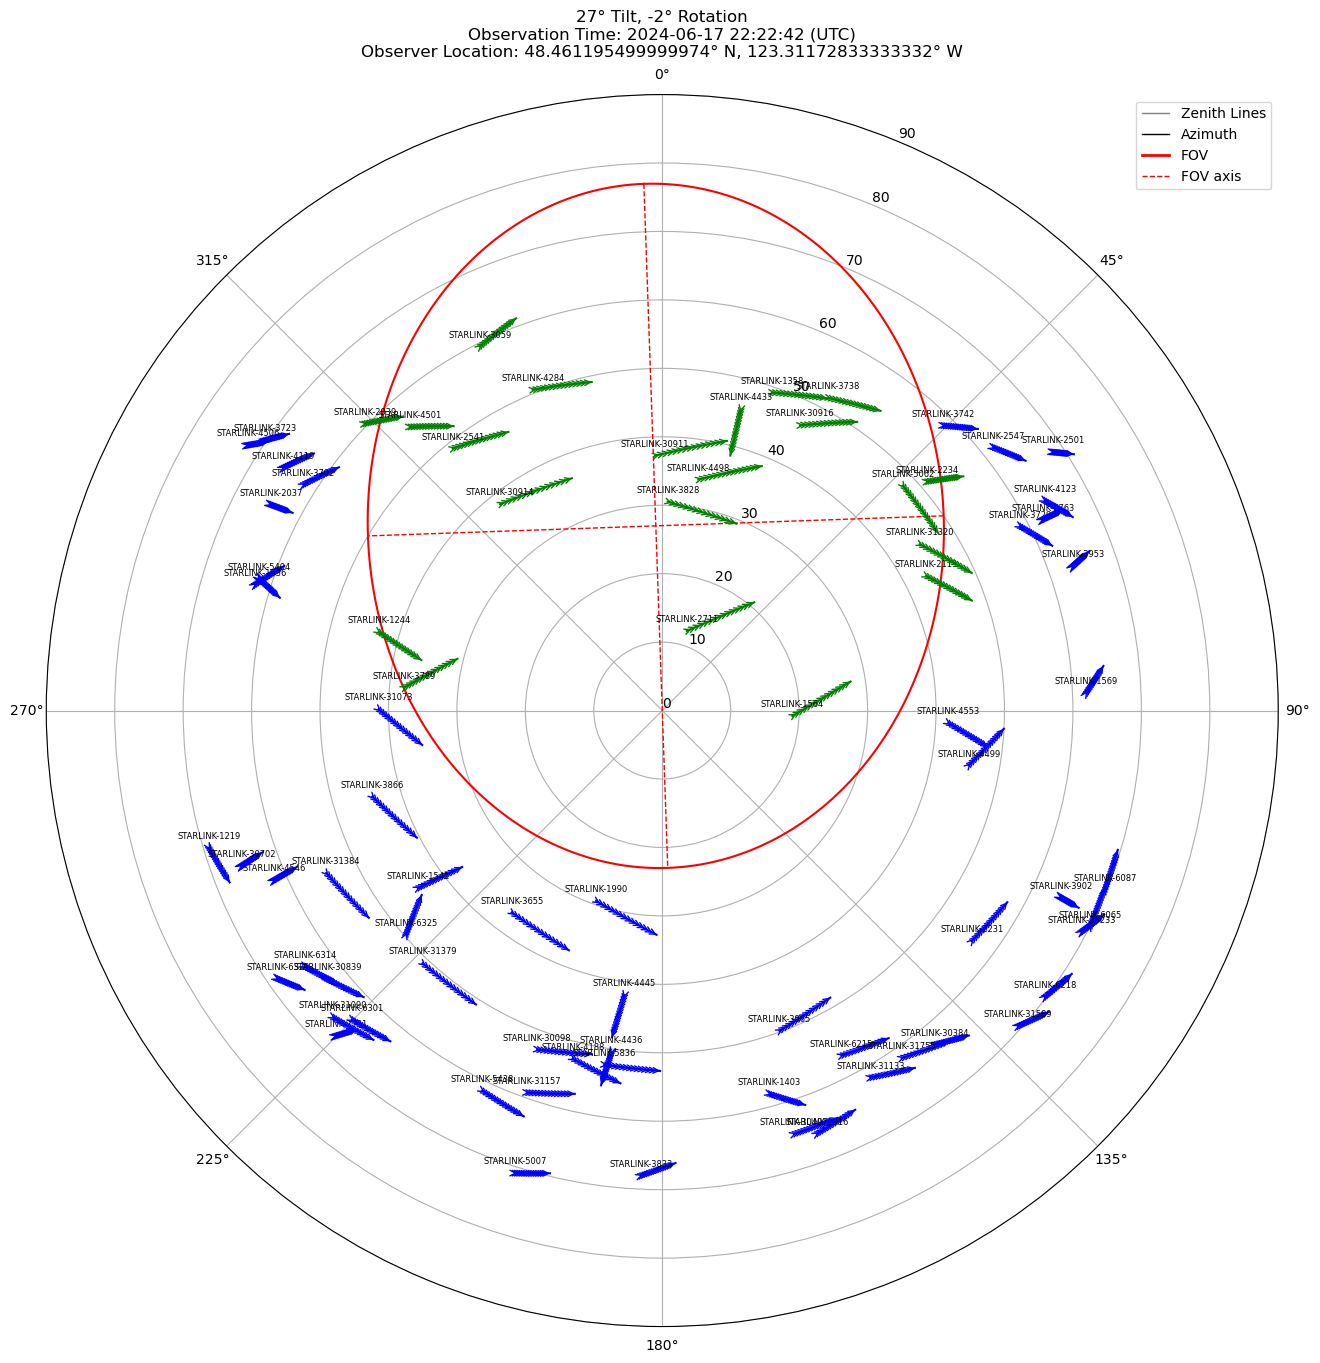

Satellites inside the FOV: ['STARLINK-1244', 'STARLINK-1358', 'STARLINK-1564', 'STARLINK-2119', 'STARLINK-2039', 'STARLINK-2541', 'STARLINK-2234', 'STARLINK-2711', 'STARLINK-3059', 'STARLINK-3738', 'STARLINK-3789', 'STARLINK-3828', 'STARLINK-4284', 'STARLINK-4498', 'STARLINK-4433', 'STARLINK-4501', 'STARLINK-5062', 'STARLINK-30911', 'STARLINK-30914', 'STARLINK-30916', 'STARLINK-31320']


In [12]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 50
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces with arrows
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        color = "g" if inside else "b"
        ax.plot(angle, r, color=color)
        for i in range(0, len(angle) - 1, max(1, len(angle) // 10)):
            ax.annotate('', xy=(angle[i + 1], r[i + 1]), xytext=(angle[i], r[i]),
                        arrowprops=dict(arrowstyle='->', color=color))
        if inside:
            inside_fov.append(satellite_name)
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 6, 17, 22, 22, 42)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    draw_fov(27, -2, positions_over_time, initial_time, observer_location)


Loaded 6148 satellites


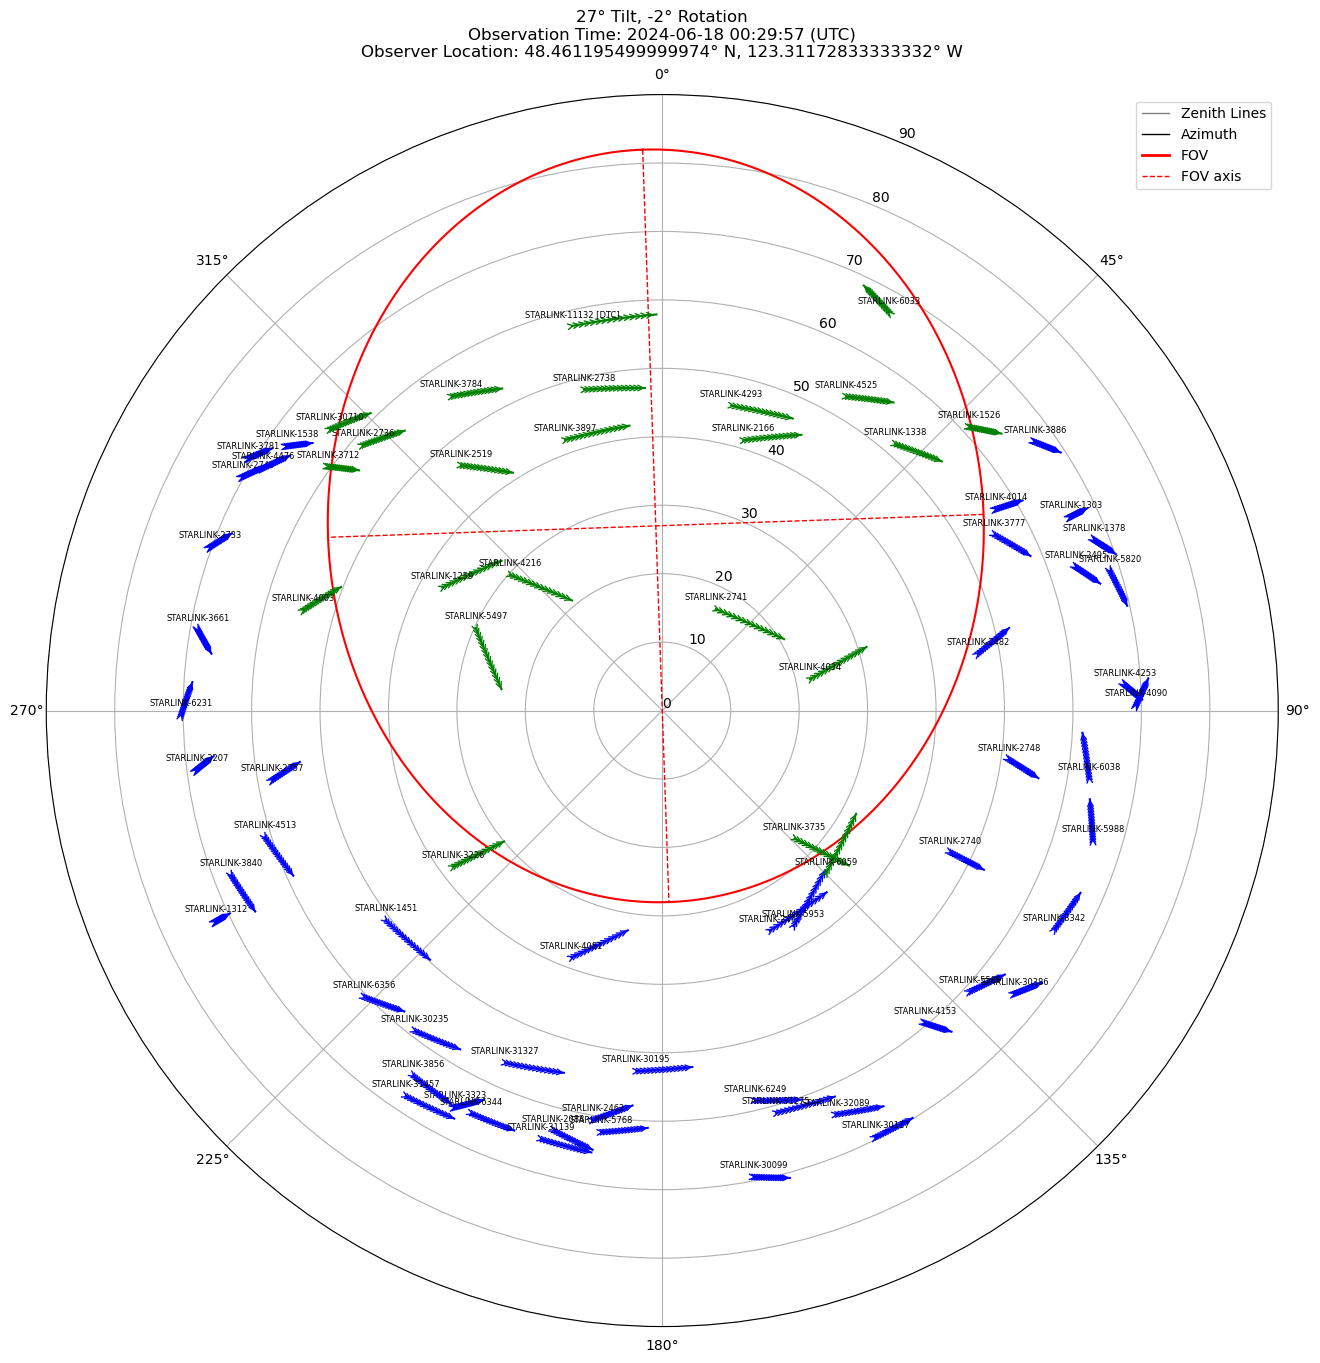

Satellites inside the FOV: ['STARLINK-1259', 'STARLINK-1338', 'STARLINK-1526', 'STARLINK-2519', 'STARLINK-2166', 'STARLINK-2736', 'STARLINK-2738', 'STARLINK-2741', 'STARLINK-3226', 'STARLINK-3712', 'STARLINK-3735', 'STARLINK-3784', 'STARLINK-3897', 'STARLINK-4034', 'STARLINK-4003', 'STARLINK-4293', 'STARLINK-4216', 'STARLINK-4525', 'STARLINK-5497', 'STARLINK-6033', 'STARLINK-6059', 'STARLINK-30710', 'STARLINK-11132 [DTC]']


In [22]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 55
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces with arrows
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        color = "g" if inside else "b"
        ax.plot(angle, r, color=color)
        for i in range(0, len(angle) - 1, max(1, len(angle) // 10)):
            ax.annotate('', xy=(angle[i + 1], r[i + 1]), xytext=(angle[i], r[i]),
                        arrowprops=dict(arrowstyle='->', color=color))
        if inside:
            inside_fov.append(satellite_name)
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 6, 18, 0, 29, 57)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=67)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    draw_fov(27, -2, positions_over_time, initial_time, observer_location)


Loaded 6148 satellites


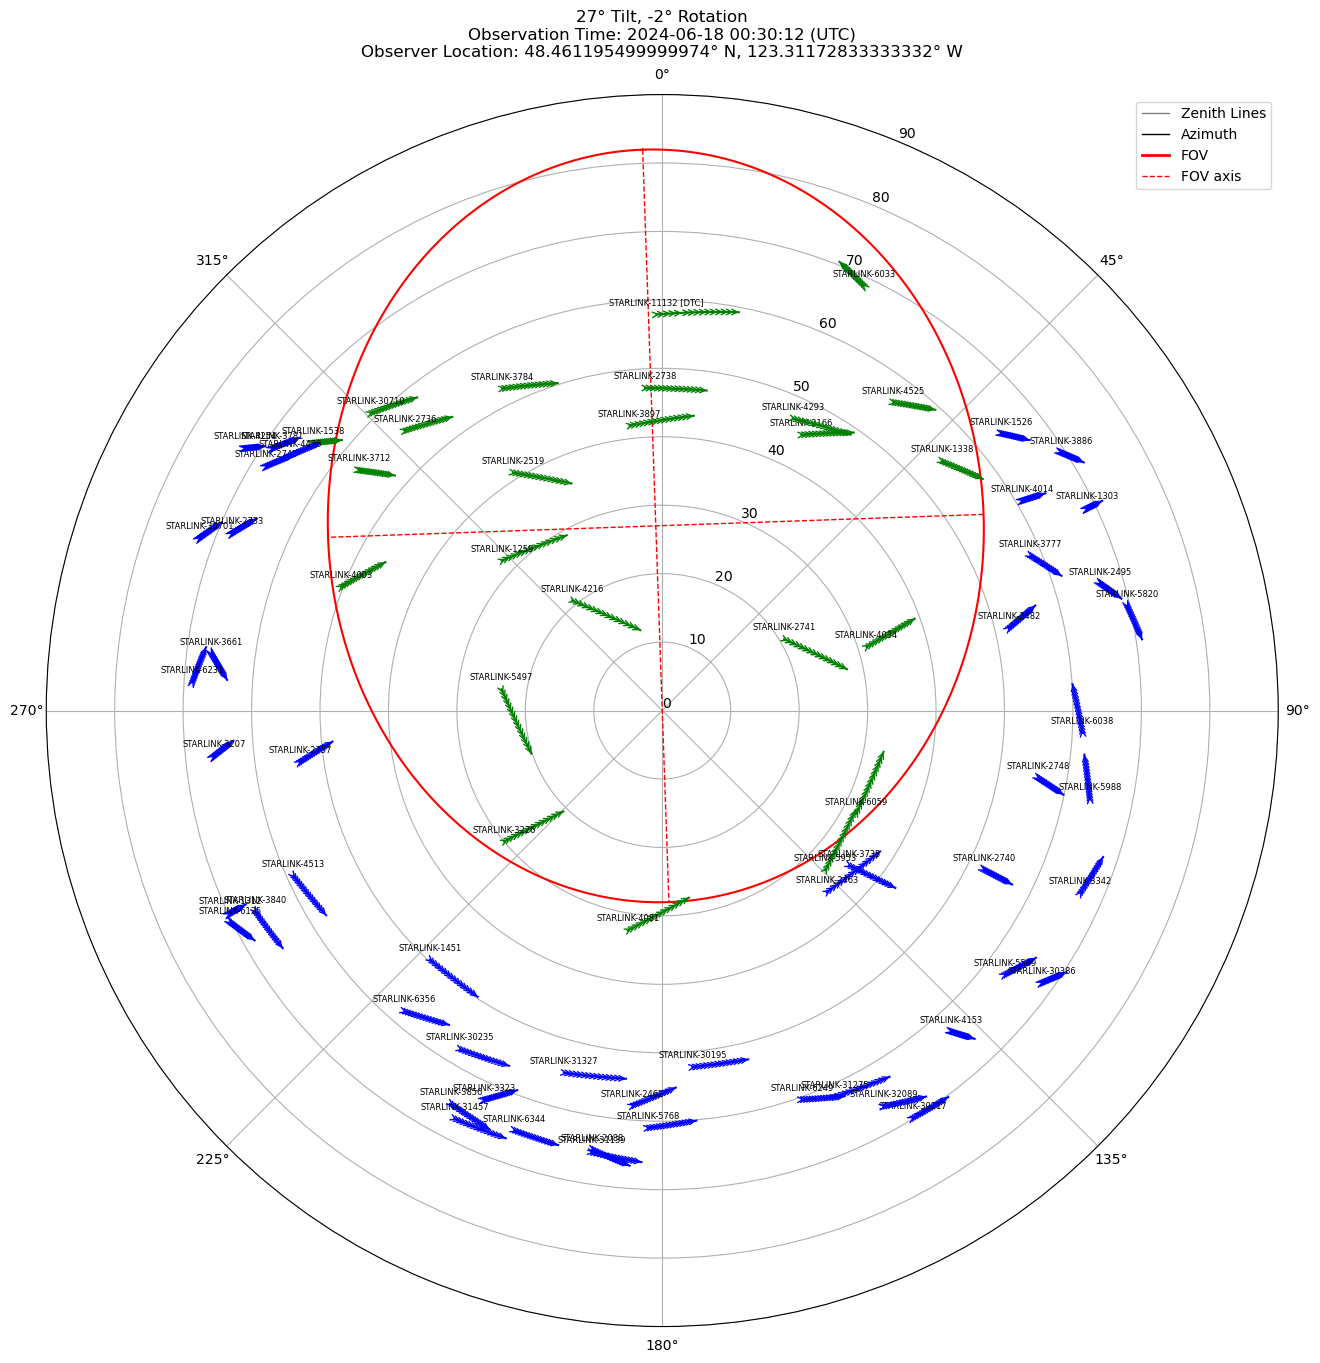

Satellites inside the FOV: ['STARLINK-1259', 'STARLINK-1338', 'STARLINK-1538', 'STARLINK-2519', 'STARLINK-2166', 'STARLINK-2736', 'STARLINK-2738', 'STARLINK-2741', 'STARLINK-3226', 'STARLINK-3712', 'STARLINK-3784', 'STARLINK-3897', 'STARLINK-4081', 'STARLINK-4034', 'STARLINK-4003', 'STARLINK-4293', 'STARLINK-4216', 'STARLINK-4525', 'STARLINK-5497', 'STARLINK-6033', 'STARLINK-5953', 'STARLINK-6059', 'STARLINK-30710', 'STARLINK-11132 [DTC]']


In [23]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 55
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces with arrows
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        color = "g" if inside else "b"
        ax.plot(angle, r, color=color)
        for i in range(0, len(angle) - 1, max(1, len(angle) // 10)):
            ax.annotate('', xy=(angle[i + 1], r[i + 1]), xytext=(angle[i], r[i]),
                        arrowprops=dict(arrowstyle='->', color=color))
        if inside:
            inside_fov.append(satellite_name)
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 6, 18, 0, 30, 12)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=67)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    draw_fov(27, -2, positions_over_time, initial_time, observer_location)


Loaded 6148 satellites


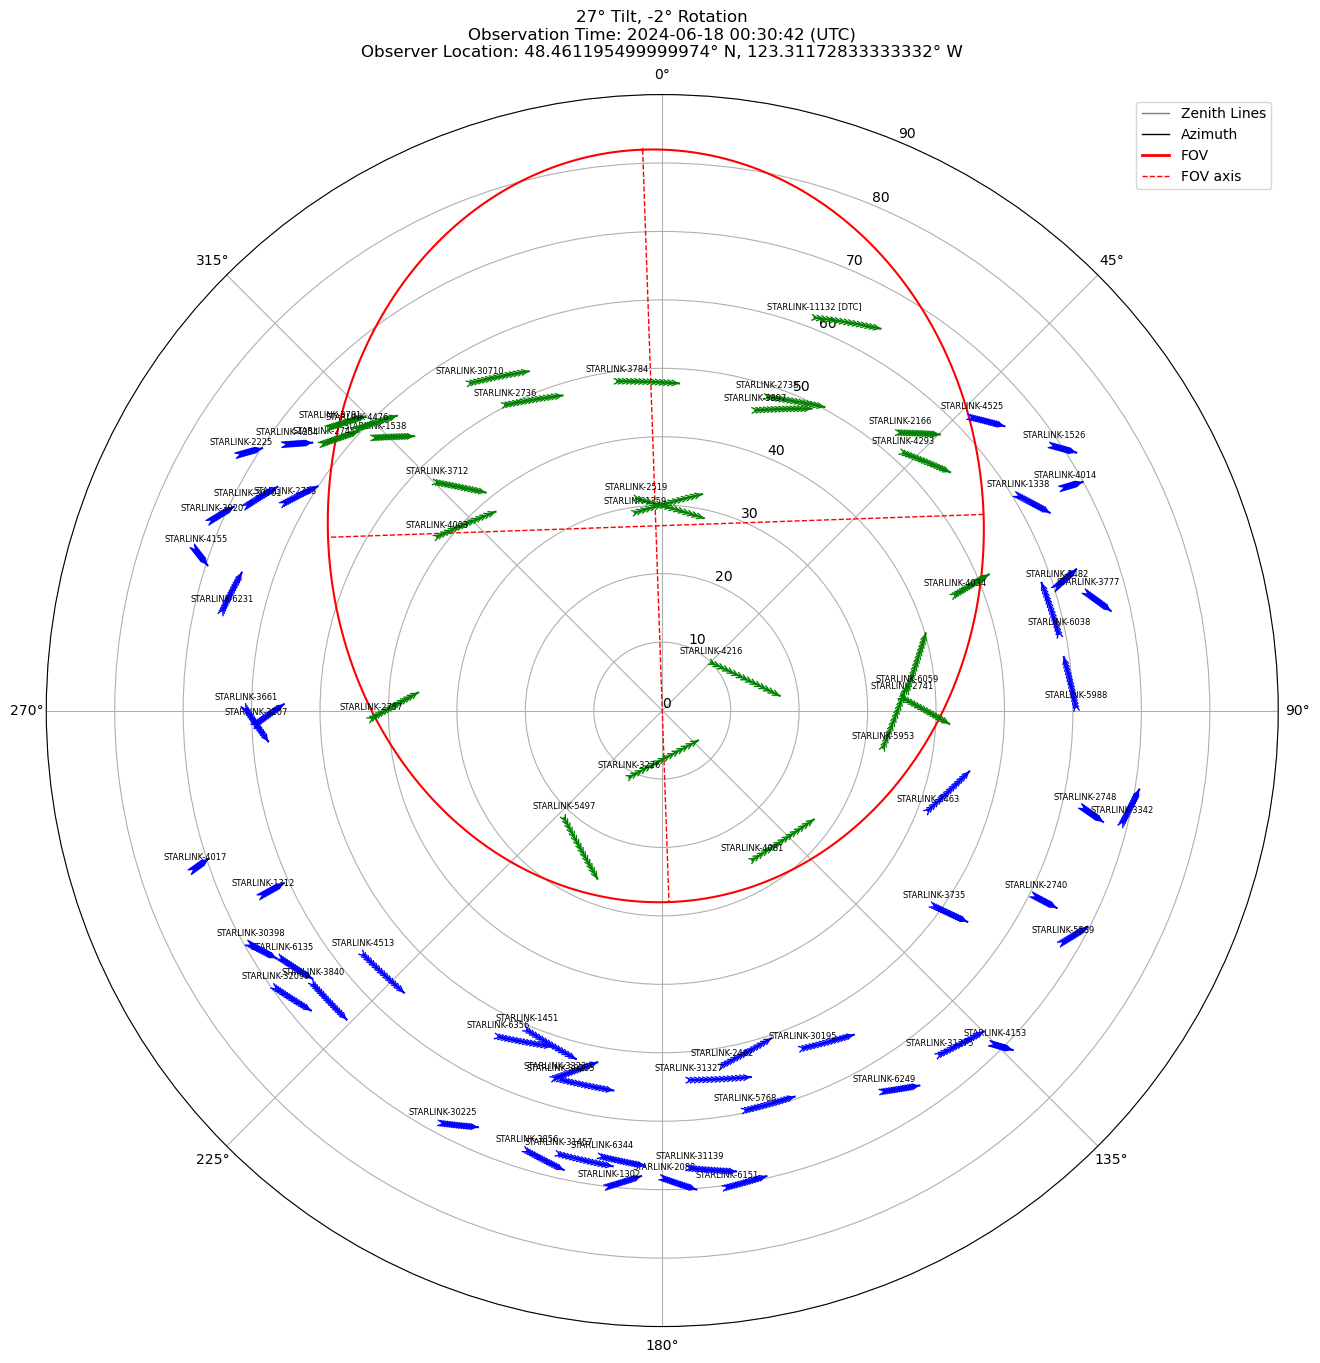

Satellites inside the FOV: ['STARLINK-1259', 'STARLINK-1538', 'STARLINK-2519', 'STARLINK-2166', 'STARLINK-2757', 'STARLINK-2736', 'STARLINK-2738', 'STARLINK-2745', 'STARLINK-2741', 'STARLINK-3226', 'STARLINK-3712', 'STARLINK-3781', 'STARLINK-3784', 'STARLINK-3897', 'STARLINK-4081', 'STARLINK-4034', 'STARLINK-4003', 'STARLINK-4293', 'STARLINK-4216', 'STARLINK-4476', 'STARLINK-5497', 'STARLINK-5953', 'STARLINK-6059', 'STARLINK-30710', 'STARLINK-11132 [DTC]']


In [19]:
from skyfield.api import load, wgs84
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now():
    ts = load.timescale()
    return ts.now() - timedelta(seconds=1)

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions_over_time(satellites, observer_location, start_time, interval_seconds):
    positions_over_time = {}
    min_elevation = 20
    for satellite in satellites:
        positions = []
        altitudes = []
        for second in range(interval_seconds + 1):
            current_time = start_time + timedelta(seconds=second)
            difference = satellite - observer_location
            topocentric = difference.at(current_time)
            alt, az, distance = topocentric.altaz()
            positions.append((90 - alt.degrees, np.radians(az.degrees)))
            altitudes.append(alt.degrees)
        if any(alt > min_elevation for alt in altitudes):
            positions_over_time[satellite.name] = positions
    return positions_over_time

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, positions_over_time, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 55
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellite traces with arrows
    for satellite_name, positions in positions_over_time.items():
        r = [pos[0] for pos in positions]
        angle = [pos[1] for pos in positions]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        color = "g" if inside else "b"
        ax.plot(angle, r, color=color)
        for i in range(0, len(angle) - 1, max(1, len(angle) // 10)):
            ax.annotate('', xy=(angle[i + 1], r[i + 1]), xytext=(angle[i], r[i]),
                        arrowprops=dict(arrowstyle='->', color=color))
        if inside:
            inside_fov.append(satellite_name)
        ax.annotate(satellite_name, xy=(angle[0], r[0]), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')

    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 6, 18, 0, 30, 42)
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=67)
    interval_seconds = 15
    positions_over_time = calculate_satellite_positions_over_time(satellites, observer_location, initial_time, interval_seconds)
    draw_fov(27, -2, positions_over_time, initial_time, observer_location)
